#### Summary

In this Jupyter notebook we are going to take a dataset that includes a number of student performance factors and seek to lower the dimensionality of the features through PCA. After that, we are going to attempt to categorize students into different groups using both the reduced features as well as the non-reduced features through NMF. Finally, we will attempt to predict a student's final exam score using these classifications. Before startting, I am unsure of how accurate we will be able to get with this method but it is interesting to me from a theoretical standpoint.

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA, NMF
import time
from seaborn import heatmap

#### EDA And Data Cleaning

First let's import the data and do some preliminary analysis to see what we have. The data comes from https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/data and is a collection of student performance factors. It includes the categories below.

In [182]:
data = pd.read_csv("data/StudentPerformanceFactors.csv")
data.dropna(inplace = True)
print(data.info())

#Creating an array with the final score for later comparison
scores = data["Exam_Score"]
categories = len(scores.unique())

data.drop(columns = "Exam_Score", inplace = True)


<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6378 non-null   int64 
 1   Attendance                  6378 non-null   int64 
 2   Parental_Involvement        6378 non-null   object
 3   Access_to_Resources         6378 non-null   object
 4   Extracurricular_Activities  6378 non-null   object
 5   Sleep_Hours                 6378 non-null   int64 
 6   Previous_Scores             6378 non-null   int64 
 7   Motivation_Level            6378 non-null   object
 8   Internet_Access             6378 non-null   object
 9   Tutoring_Sessions           6378 non-null   int64 
 10  Family_Income               6378 non-null   object
 11  Teacher_Quality             6378 non-null   object
 12  School_Type                 6378 non-null   object
 13  Peer_Influence              6378 non-null   object
 1

As we can see, we have quite a few columns that are filled with objects that we need to change to be numbers.

In [183]:
codes = {}
data["Parental_Involvement"], codes["Parental_Involvement"] = pd.factorize(data["Parental_Involvement"])
data["Access_to_Resources"], codes["Access_to_Resources"] = pd.factorize(data["Access_to_Resources"])
data["Extracurricular_Activities"], codes["Extracurricular_Activities"] = pd.factorize(data["Extracurricular_Activities"])
data["Motivation_Level"], codes["Motivation_Level"] = pd.factorize(data["Motivation_Level"])
data["Internet_Access"], codes["Internet_Access"] = pd.factorize(data["Internet_Access"])
data["Family_Income"], codes["Family_Income"] = pd.factorize(data["Family_Income"])
data["Teacher_Quality"], codes["Teacher_Quality"] = pd.factorize(data["Teacher_Quality"])
data["School_Type"], codes["School_Type"] = pd.factorize(data["School_Type"])
data["Peer_Influence"], codes["Peer_Influence"] = pd.factorize(data["Peer_Influence"])
data["Learning_Disabilities"], codes["Learning_Disabilities"] = pd.factorize(data["Learning_Disabilities"])
data["Parental_Education_Level"], codes["Parental_Education_Level"] = pd.factorize(data["Parental_Education_Level"])
data["Distance_from_Home"], codes["Distance_from_Home"] = pd.factorize(data["Distance_from_Home"])
data["Gender"], codes["Gender"] = pd.factorize(data["Gender"])

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Hours_Studied               6378 non-null   int64
 1   Attendance                  6378 non-null   int64
 2   Parental_Involvement        6378 non-null   int64
 3   Access_to_Resources         6378 non-null   int64
 4   Extracurricular_Activities  6378 non-null   int64
 5   Sleep_Hours                 6378 non-null   int64
 6   Previous_Scores             6378 non-null   int64
 7   Motivation_Level            6378 non-null   int64
 8   Internet_Access             6378 non-null   int64
 9   Tutoring_Sessions           6378 non-null   int64
 10  Family_Income               6378 non-null   int64
 11  Teacher_Quality             6378 non-null   int64
 12  School_Type                 6378 non-null   int64
 13  Peer_Influence              6378 non-null   int64
 14  Physical_Acti

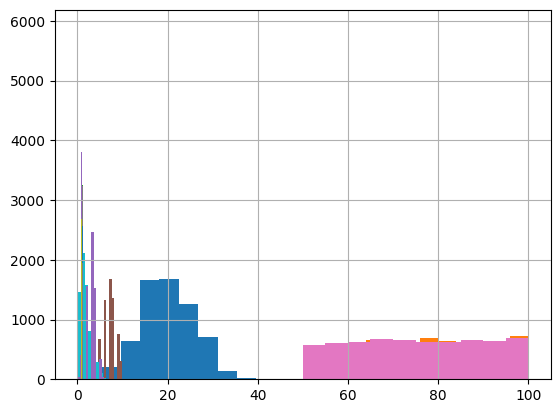

In [184]:
print(data.info())
for column in data.columns:
    data[column].hist()

<Axes: >

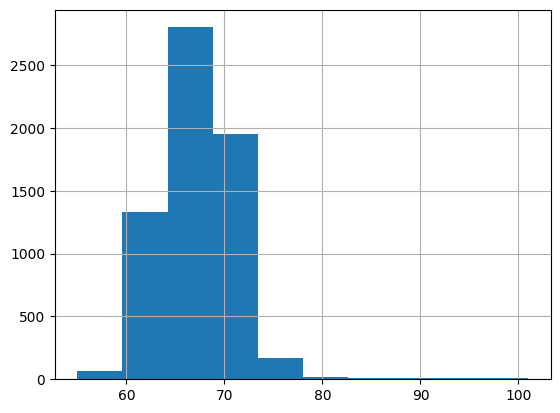

In [185]:
scores.hist()

In [186]:
data.describe()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
count,6378.000000,6378.000000,6378.00000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000,6378.000000
mean,19.977109,80.020853,1.08545,0.901850,0.596896,7.034964,75.066165,0.907965,0.076043,1.495296,0.788021,0.501568,0.304798,0.990906,2.972719,0.104735,0.705394,0.503763,0.421762
std,5.985460,11.550723,0.69502,0.698635,0.490560,1.468033,14.400389,0.695758,0.265087,1.233984,0.743526,0.673018,0.460358,0.889670,1.028926,0.306236,0.780570,0.670442,0.493880
min,1.000000,60.000000,0.00000,0.000000,0.000000,4.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,70.000000,1.00000,0.000000,0.000000,6.000000,63.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,80.000000,1.00000,1.000000,1.000000,7.000000,75.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000
75%,24.000000,90.000000,2.00000,1.000000,1.000000,8.000000,88.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000
max,44.000000,100.000000,2.00000,2.000000,1.000000,10.000000,100.000000,2.000000,1.000000,8.000000,2.000000,2.000000,1.000000,2.000000,6.000000,1.000000,2.000000,2.000000,1.000000


From the above, we can get a better idea of the various pieces of each of the columns, even if a histogram of all the columns at once isn't the most useful. It shows us succinctly that all of the columns will have values between 0 and 100, with most of them being between 0 and 10. However, lets normalize every column to have values between 0 and 1.

In [187]:
scaling = StandardScaler()
scaling.fit(data)
normed_data = pd.DataFrame(scaling.transform(data))

In [188]:
normed_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03,6.378000e+03
mean,-1.693360e-16,5.458858e-16,-7.686963e-17,-4.372656e-17,1.671079e-17,-1.030499e-16,4.634459e-16,-7.241342e-17,7.297044e-17,1.002647e-17,-5.347452e-17,-2.228105e-17,-7.352747e-17,7.018531e-17,8.021179e-17,-6.238694e-17,7.464152e-17,-8.021179e-17,-1.236598e-16
std,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00,1.000078e+00
min,-3.170784e+00,-1.733435e+00,-1.561876e+00,-1.290975e+00,-1.216859e+00,-2.067530e+00,-1.740795e+00,-1.305103e+00,-2.868816e-01,-1.211858e+00,-1.059926e+00,-7.453100e-01,-6.621407e-01,-1.113879e+00,-2.889375e+00,-3.420347e-01,-9.037617e-01,-7.514487e-01,-8.540449e-01
25%,-6.645138e-01,-8.676200e-01,-1.229557e-01,-1.290975e+00,-1.216859e+00,-7.050558e-01,-8.379712e-01,-1.305103e+00,-2.868816e-01,-4.014114e-01,-1.059926e+00,-7.453100e-01,-6.621407e-01,-1.113879e+00,-9.454473e-01,-3.420347e-01,-9.037617e-01,-7.514487e-01,-8.540449e-01
50%,3.824766e-03,-1.805477e-03,-1.229557e-01,1.404990e-01,8.217876e-01,-2.381873e-02,-4.595024e-03,1.322907e-01,-2.868816e-01,-4.014114e-01,2.851215e-01,-7.453100e-01,-6.621407e-01,1.022230e-02,2.651641e-02,-3.420347e-01,3.774546e-01,-7.514487e-01,-8.540449e-01
75%,6.721634e-01,8.640091e-01,1.315964e+00,1.404990e-01,8.217876e-01,6.574183e-01,8.982292e-01,1.322907e-01,-2.868816e-01,4.090356e-01,2.851215e-01,7.406504e-01,1.510253e+00,1.134323e+00,9.984802e-01,-3.420347e-01,3.774546e-01,7.402226e-01,1.170899e+00
max,4.013856e+00,1.729824e+00,1.315964e+00,1.571973e+00,8.217876e-01,2.019892e+00,1.731605e+00,1.569684e+00,3.485759e+00,5.271718e+00,1.630169e+00,2.226611e+00,1.510253e+00,1.134323e+00,2.942408e+00,2.923680e+00,1.658671e+00,2.231894e+00,1.170899e+00


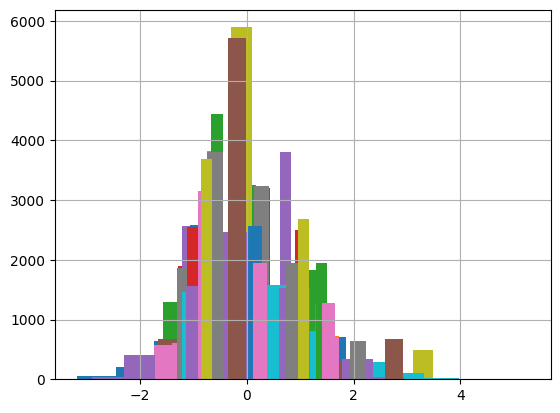

In [189]:
for column in normed_data.columns:
    normed_data[column].hist()

#### PCA

Let's start by converting this data into a PCA in order to see how it shrinks down the feature space when it seeks to target 90% of the variance.

In [190]:
pca = PCA(n_components = 0.8, svd_solver = "full")
pca_data = pca.fit_transform(normed_data)

In [191]:
print(pca.explained_variance_ratio_)

[0.0575473  0.05698476 0.05641867 0.05554611 0.05529435 0.05474453
 0.05389619 0.05354437 0.05283836 0.05221989 0.05186862 0.05148582
 0.05141653 0.05110133 0.05038873]


It appears that there needs to still be 15 features to keep an explained variance of more than 80%. As such, the PCA did not considerably reduce the number of features but did reduce it somewhat. Beyond that, each of the remaining features explain about 5% of the variance within. It is difficult to provide meaningful visual representation of this data as each of the 15 features include parts of the original 19 features.

#### NMF

First, however, we need to go back to our non-pca data as NMF requires non negative values.

Let's try to see if we can predict categories of students from the data set. The logic of this step is that we are going to decompose this larger feature matrix into matrices. The first will include all the students as the rows and then the various categories or labels as the columns. The second one will include labels x features. The first matrix will allow us to predict which of the categories each student falls under. 

If we set the number of categories to the number of different final scores that the students in the set had, I am curious whether or not these categories will line up with these scores. Unfortunately, the size of this is too large for my computer to attempt.

Instead, let's predict a total of 5 groups and then see how well those groups line up in terms of actual final exam score. We will take the categories that the students are sroted into, get the average of their previous exams scores, and then use that to predict the new one. We can calculate the RMSE from this value to get an idea of accuracy.

In [192]:
def rmse(y, yp):
    return np.sqrt(((y-yp)**2).mean())

def predict_scores(scores, name):
    predictions = scores.groupby(name)["Previous_Scores"].mean()
    return scores[name].apply(lambda x: predictions[x] )

def get_rmse(scores, name):
    predictions = predict_scores(scores, name)
    return rmse(scores["Exam_Score"],predictions)

In [199]:
scores = pd.DataFrame(scores)
scores["Previous_Scores"] = data["Previous_Scores"]

In [206]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)
train_scores, test_scores = train_test_split(scores, test_size = 0.2, random_state = 42)

In [207]:
nmf = NMF(n_components = 5,
              solver = "mu",
              beta_loss = "kullback-leibler")
W = nmf.fit_transform(train)

In [208]:
predictions = W.argmax(axis = 1)
print(predictions)
print(len(predictions))

[3 2 4 ... 4 3 3]
5102


In [209]:
train_scores["predictions_5"] = predictions

In [210]:
train_scores.groupby("predictions_5")["Exam_Score"].mean()

predictions_5
0    66.689243
1    67.809035
2    66.070396
3    69.118984
4    66.416601
Name: Exam_Score, dtype: float64

predictions_5
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
Name: Exam_Score, dtype: object

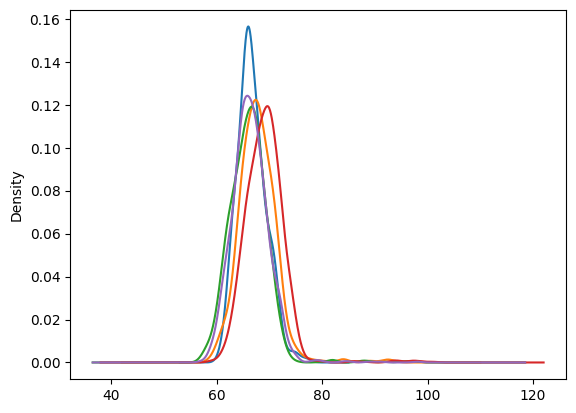

In [211]:
train_scores.groupby("predictions_5")["Exam_Score"].plot(kind = "kde")

In [212]:
print(get_rmse(train_scores, "predictions_5"))
print(rmse(train_scores["Previous_Scores"], scores["Exam_Score"]) )

10.191389831996302
16.295169108060527


However, it does not seem like this method is scaling well onto exam score and is likely that the categories that the NNM is finding are more related to the type of student that each student is, rather than the final exam score that they each would have. This is shown by each of the predicted groups having close average exam scores, as shown in the table above. However, what happens if we try this for different numbers of groups? Does this table improve?

Visually, it does not seem like the labels are mapping well onto final exam score. However, the RMSE of using labels and previous exam score to map onto future exam score of 10.05 implies that it is at least slightly working. To compare this, the RMSE of simply comparing previous scores to Exam scores is much higher. What happens if we raise the number of labels?

In [214]:
nmf = NMF(n_components = 7,
              solver = "mu",
              beta_loss = "kullback-leibler")
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_7"] = predictions
train_scores.groupby("predictions_7")["Exam_Score"].mean()

/home/jkagie/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


predictions_7
0    64.176471
1    67.374172
2    66.214953
3    68.970696
4    66.371330
5    67.472379
6    65.222222
Name: Exam_Score, dtype: float64

predictions_7
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
5    Axes(0.125,0.11;0.775x0.77)
6    Axes(0.125,0.11;0.775x0.77)
Name: Exam_Score, dtype: object

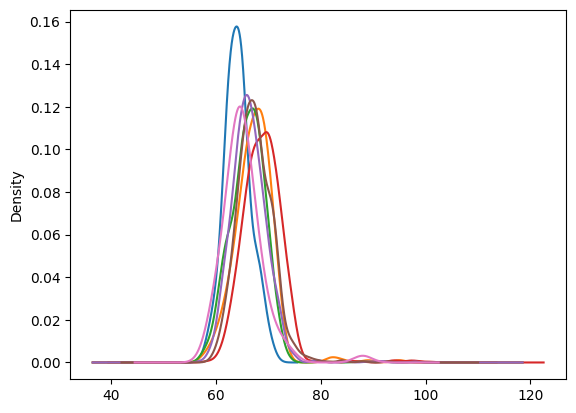

In [215]:
train_scores.groupby("predictions_7")["Exam_Score"].plot(kind = "kde")

In [216]:
print(get_rmse(train_scores, "predictions_7"))

9.777439715409242


In [217]:
nmf = NMF(n_components = 9,
              solver = "mu",
              beta_loss = "kullback-leibler")
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_9"] = predictions
train_scores.groupby("predictions_9")["Exam_Score"].mean()

/home/jkagie/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


predictions_9
0    63.833333
1    67.164557
2    65.918182
3    69.006536
4    66.555556
5    68.125506
6    65.608333
7    66.771777
8    66.422460
Name: Exam_Score, dtype: float64

In [218]:
print(get_rmse(train_scores, "predictions_9"))

9.075742609575329


In [220]:
nmf = NMF(n_components = 11,
          solver = "mu",
          beta_loss = "kullback-leibler", 
          max_iter = 1000)
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_11"] = predictions
x = train_scores.groupby("predictions_11")["Exam_Score"].mean()
print(get_rmse(train_scores, "predictions_11"))

9.070640024808673


In [221]:
nmf = NMF(n_components = 15,
          solver = "mu",
          beta_loss = "kullback-leibler", 
          max_iter = 1000)
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_15"] = predictions
x = train_scores.groupby("predictions_15")["Exam_Score"].mean()
print(get_rmse(train_scores, "predictions_15"))

9.071431288538603


In [222]:
nmf = NMF(n_components = 21,
          solver = "mu",
          beta_loss = "kullback-leibler", 
          max_iter = 1000)
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_21"] = predictions
x = train_scores.groupby("predictions_21")["Exam_Score"].mean()
print(get_rmse(train_scores, "predictions_21"))

11.305853659608033


In [224]:
nmf = NMF(n_components = 45,
          solver = "mu",
          beta_loss = "kullback-leibler", 
          max_iter = 1000)
W = nmf.fit_transform(train)
predictions = W.argmax(axis = 1)
train_scores["predictions_45"] = predictions
x = train_scores.groupby("predictions_45")["Exam_Score"].mean()
print(get_rmse(train_scores, "predictions_45"))

12.073199260158633


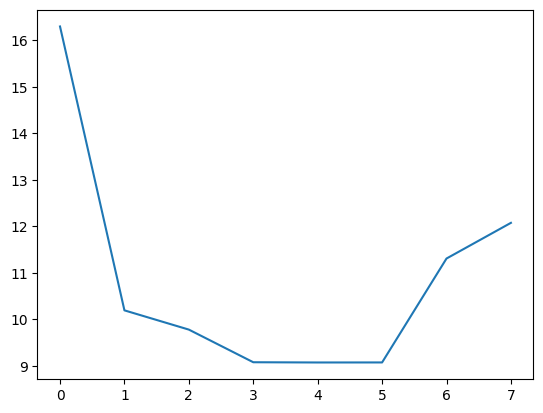

In [226]:
rmses = [rmse(scores["Previous_Scores"], train_scores["Exam_Score"]) ,get_rmse(train_scores, "predictions_5"),
         get_rmse(train_scores, "predictions_7"), get_rmse(train_scores, "predictions_9"),
         get_rmse(train_scores, "predictions_11"), get_rmse(train_scores, "predictions_15"), get_rmse(train_scores, "predictions_21"),
         get_rmse(train_scores, "predictions_45")]
plt.plot(rmses)
plt.show()

Looking at this data, it seems that the RMSE minimizes at around 15 components, with around 8 or 9 components being good enough. It goes to an RMSE of less than 9, which, given that it is predicting off previous exam scores that are worse, is quite good. It appears that the labels had considerable utility in differentiating which bucket a student came from, and then using that to account for the individual differences in test taking on the day. Note on the above plot that the x axis is not scaled, with the first value being raw predictions.

Let's see how this final model does on the test data.

In [227]:
nmf = NMF(n_components = 9,
              solver = "mu",
              beta_loss = "kullback-leibler")
nmf.fit(train)
W = nmf.transform(test)
predictions = W.argmax(axis = 1)
test_scores["predictions_9"] = predictions
x = test_scores.groupby("predictions_9")["Exam_Score"].mean()
print(get_rmse(test_scores, "predictions_9"))

9.42645194674294


/home/jkagie/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


This is still considerably better than the naive guess of just predicting the previous score, showing that this model does have considerable utility for grouping students to be used for future predictions.

#### Supervised Learning Comparison

Now that we have shown that an NMF based on predicting from a previous exam score can heavily outcompete simply predicting based on the previous exam score, let's see how a linear regression will fair on this data.

In [233]:
train_pca, test_pca = train_test_split(pca_data, test_size = 0.2, random_state = 42)

In [234]:
lr = LinearRegression()
lr.fit(train_pca, train_scores["Exam_Score"])
predictions = lr.predict(test_pca)
print(rmse(predictions, test_scores["Exam_Score"]))
lr.score(test_pca, test_scores["Exam_Score"])

2.8842564235401063


0.4646527359648529

In [235]:
lr = LinearRegression()
lr.fit(train, train_scores["Exam_Score"])
predictions = lr.predict(test)
print(rmse(predictions, test_scores["Exam_Score"]))
lr.score(test, test_scores["Exam_Score"])

2.078528663819354


0.7219775369947717

Looking at this, it is immediately obvious that the linear regression model is far more accurate than the previous model. However, this is not unexpected. This model is allowed to take into account the actual exam score when it fits its model, unlike the NMF model. 

The PCA supplied model has a considerably worse result than the complete data model, which again is unsurprising. Our PCA was set to only account for 80% of the variance, which is a large reduction in information in pursuit of speed and a smaller feature space. Overall, though, both models performed far ebtter than the unsupervised model. 

Future ideas: it would be interesting to see how this model worked when you accounted for the differences between the previous exams and future exams, but I did not because I did not want to use any knowledge of future exams.